## RNN predicting precipitation with 2nd larger Dataset

In [106]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'seattleWeather_1948-2017.csv'
data = pd.read_csv(file_path)

# Explore dataset
print(data.head())
# print(data.info())

# Check for missing values
print(data.isnull().sum())


         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True
DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64


In [107]:
# Renamings columns
data.rename(columns={'TMAX': 'temp_max', 'TMIN': 'temp_min', 'PRCP': 'precipitation', 'RAIN': 'rain'}, inplace=True)

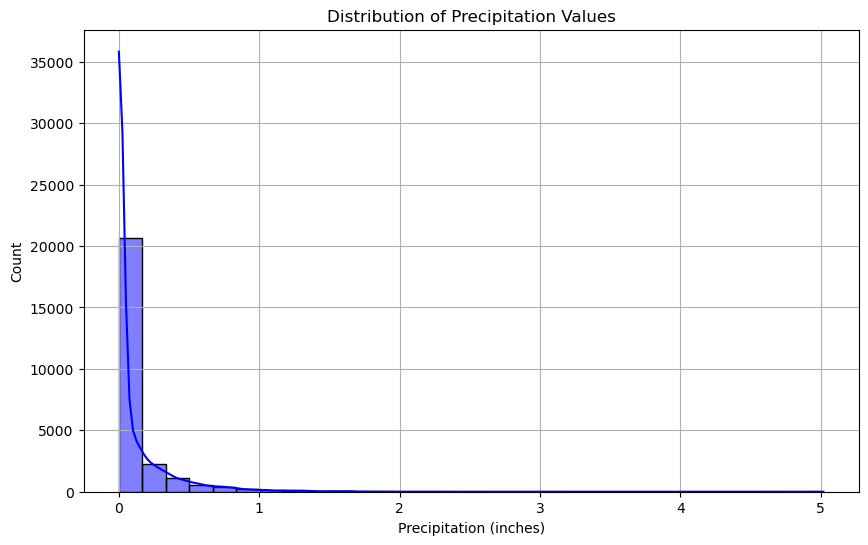

In [108]:
# Analyzing data distribution
plt.figure(figsize=(10, 6))  # Set figure size
sns.histplot(data['precipitation'], bins=30, kde=True, color='blue')  # Plot histogram with KDE
plt.title('Distribution of Precipitation Values')  # Title
plt.xlabel('Precipitation (inches)')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.grid(True)  # Add grid
plt.show()  # Show the plot

In [109]:
# Drop rows with missing values
data.dropna(subset=['precipitation', 'rain'], inplace=True)

## testing something

In [110]:
#test
# data['precipitation_log'] = np.log1p(data['precipitation'])

In [111]:
# Encode the rain column (TRUE/FALSE to 1/0)
data['rain'] = data['rain'].apply(lambda x: 1 if x == 'TRUE' else 0)

In [112]:
# Normalize features
features_to_scale = ['temp_max', 'temp_min', 'rain']
scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Normalize precipitation column 
precipitation_scaler = MinMaxScaler()
data['precipitation_scaled'] = precipitation_scaler.fit_transform(data[['precipitation']])

In [113]:
# Sequence  length
seq_length = 7

X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[['temp_max', 'temp_min', 'rain']].iloc[i:i+seq_length].values)
    y.append(data['precipitation_scaled'].iloc[i+seq_length])  # Target is precipitation

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (25541, 7, 3)
Shape of y: (25541,)


In [114]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (20432, 7, 3)
Shape of X_test: (5109, 7, 3)
Shape of y_train: (20432,)
Shape of y_test: (5109,)


In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input

# Build the RNN model
# rnn_model = Sequential([
#     Input(shape=(X_train.shape[1], X_train.shape[2])),  # Input shape
#     SimpleRNN(32, activation='tanh', return_sequences=False),  # RNN layer
#     Dropout(0.3),  # Dropout for regularization
#     Dense(1)  # Single output for regression
# ])

# Stacked RNN best one so far
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(64, activation='tanh', return_sequences=True),  # First RNN layer
    Dropout(0.3),
    SimpleRNN(32, activation='tanh', return_sequences=False),  # Second RNN layer
    Dropout(0.3),
    Dense(1)  # Output layer
])

#LSTM seems to be worse
# rnn_model = Sequential([
#     Input(shape=(X_train.shape[1], X_train.shape[2])),
#     LSTM(64, activation='tanh', return_sequences=True),
#     Dropout(0.3),
#     LSTM(32, activation='tanh', return_sequences=False),
#     Dropout(0.3),
#     Dense(1)  # Output layer
# ])
#GRU not that good
# rnn_model = Sequential([
#     Input(shape=(X_train.shape[1], X_train.shape[2])),
#     GRU(64, activation='tanh', return_sequences=True),
#     Dropout(0.3),
#     GRU(32, activation='tanh', return_sequences=False),
#     Dropout(0.3),
#     Dense(1)  # Output layer
# ])
print(rnn_model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 7, 64)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,489 (29.25 KB)

 Trainable params: 7,489 (29.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [116]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [117]:
# Train the model
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1838 - mae: 0.3157 - val_loss: 0.0025 - val_mae: 0.0371
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - mae: 0.1065 - val_loss: 0.0024 - val_mae: 0.0378
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - mae: 0.0778 - val_loss: 0.0022 - val_mae: 0.0339
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mae: 0.0647 - val_loss: 0.0021 - val_mae: 0.0246
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - mae: 0.0557 - val_loss: 0.0021 - val_mae: 0.0297
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - mae: 0.0509 - val_loss: 0.0021 - val_mae: 0.0302
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - mae: 0.0461 - val_loss: 0.0021 - val_mae: 0.0317
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - mae: 0.0426 - val_loss: 0.0020 - val_mae: 0.0259
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

In [118]:
# Evaluate the model
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0020
Test MAE: 0.0269


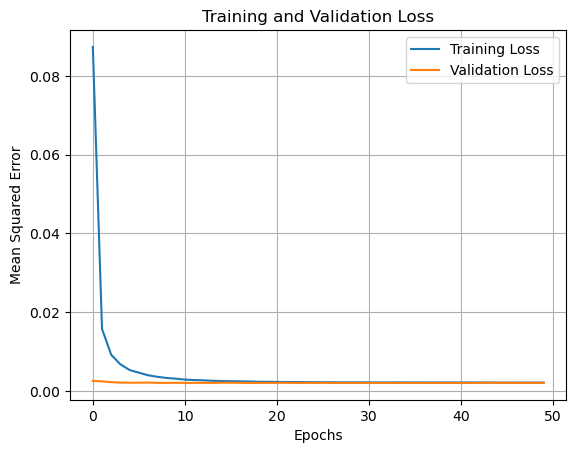

In [119]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

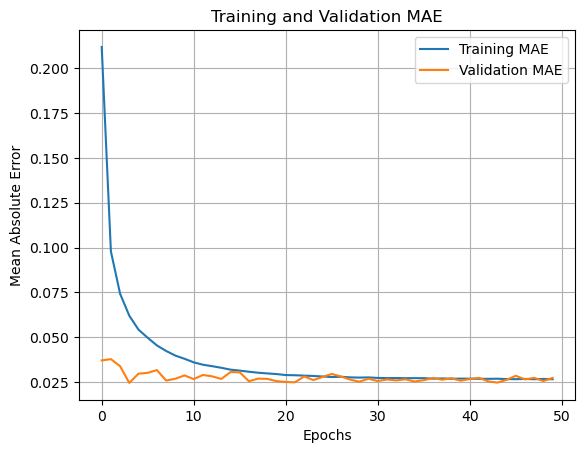

In [120]:
# Plot training and validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

## Trying to vizualize actual predictions

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


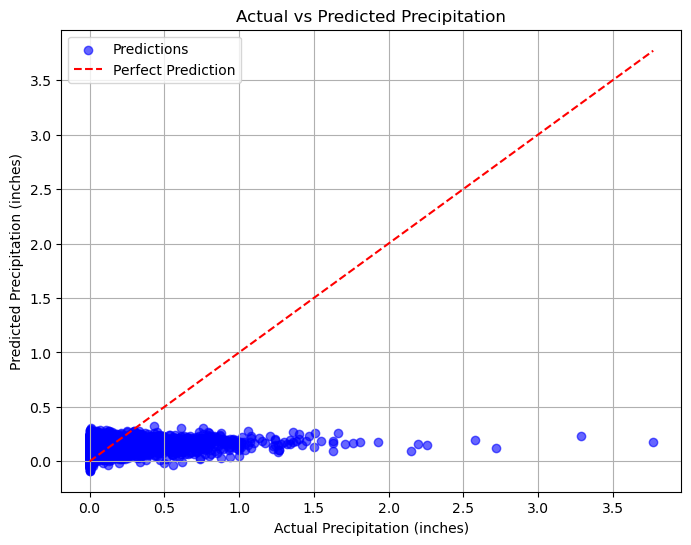

In [124]:
predictions_scaled = rnn_model.predict(X_test)
predictions = precipitation_scaler.inverse_transform(predictions_scaled)
actuals = precipitation_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Actaul vs predicted scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([0, max(actuals)], [0, max(actuals)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Precipitation')
plt.xlabel('Actual Precipitation (inches)')
plt.ylabel('Predicted Precipitation (inches)')
plt.legend()
plt.grid(True)
plt.show()